In [1]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import seaborn as sns
from itertools import chain
import shapely.vectorized as sv

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_statistic as ART_sta
from function import ART_downscale as ART_down

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## BIAS CORRECTION USING MEVD MAPS

In [2]:
# product, time_reso, ncolor = 'IMERG', '1dy', 0
# product, time_reso, ncolor = 'CMORPH', '3h', 1
# product, time_reso, ncolor = 'MSWEP', '3h', 2
# product, time_reso, ncolor = 'ERA5', '3h', 3
# product, time_reso, ncolor = 'GSMaP', '3h', 4
product, time_reso, ncolor = 'CHIRPS', '1dy', 5

In [3]:
frac = 0.7
seed = 7

In [4]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'DEM','Italy_dem_800.geojson')) 
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite')
down_base = os.path.join(sat_base,'5_DOWN')
dir_font = os.path.join('/')
obs_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC')

In [6]:
italy_geom = ITALY.union_all()

In [7]:
dir_in = os.path.join(down_base, f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')

DATA = xr.open_dataset(dir_in)

lons, lats = DATA.lon.data, DATA.lat.data
lon2dIM, lat2dIM = np.meshgrid(DATA.lon.data, DATA.lat.data)

MEVd_IM = DATA.Mev_d

mask_italy = sv.contains(italy_geom, lon2dIM, lat2dIM)
MEVd_IM = MEVd_IM.where(mask_italy)
MEVd_IM = MEVd_IM[3,:,:].values

In [8]:
def get_parameters(product, dir_base, val_max=1.1, corrected=False, corr_method=None):
    # The list bellow is the rain gauges with suspect data
    list_remove = [
            'IT-820_1424_FTS_1440_QCv4.csv', 'IT-250_602781_FTS_1440_QCv4.csv', 
            'IT-250_602779_FTS_1440_QCv4.csv', 'IT-780_2370_FTS_1440_QCv4.csv', 
            'IT-750_450_FTS_1440_QCv4.csv', 'IT-520_TOS11000099_FTS_1440_QCv4.csv',
            'IT-520_TOS11000080_FTS_1440_QCv4.csv', 'IT-520_TOS11000072_FTS_1440_QCv4.csv',
            'IT-520_TOS11000060_FTS_1440_QCv4.csv', 'IT-520_TOS11000025_FTS_1440_QCv4.csv',
            'IT-520_TOS09001200_FTS_1440_QCv4.csv', 'IT-520_TOS02000237_FTS_1440_QCv4.csv',
            'IT-230_1200_FTS_1440_QCv4.csv'
            ]

    if corrected == True:
        if corr_method == 'QQc':
            print(f"Loading {product} corrected statistics...")
            hdf5_file = os.path.join(dir_base,'statistics','QQc',f'statistics_obs_{product}_corrected_{corr_method}.h5')
        else:
            raise ValueError("corr_method must be specified between 'QQc' or 'LRC' when corrected=True")
    else:
        hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}.h5')
    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_QUANTILES = [k for k in keys if k.endswith("/QUANTILES")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]

    stations = []
    lats, lons, elevs = [], [], []
    Nobs, Cobs, Wobs = [], [], []
    OBS, MEVd = [], []
    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            continue
        else:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            Obs_ = data[keys_QUANTILES[nn]].OBS.values[3]
            Down_ = data[keys_QUANTILES[nn]].SAT_down.values[3] 

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            OBS.append(Obs_)
            MEVd.append(Down_)

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'OBS':OBS, 'MEVd':MEVd})

    return DF_DATA

In [9]:
dir_ = os.path.join('/','media','arturo','T9','Data','Italy')
DF_INPUT = get_parameters(product,dir_)

In [10]:
METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA_CLEAR = METADATA[METADATA['File'].isin(DF_INPUT['STATION'])].reset_index(drop=True)

Q_train_list = []
Q_val_list = []

for iso in METADATA_CLEAR['ISO'].unique():

    META_iso = METADATA_CLEAR[METADATA_CLEAR['ISO'] == iso]

    # Si una región tiene muy pocas estaciones, evita errores
    if len(META_iso) < 2:
        Q_train_list.append(META_iso)
        continue

    META_80 = META_iso.sample(frac=frac, random_state=seed)
    META_20 = META_iso.drop(META_80.index)

    Q_train_list.append(META_80)
    Q_val_list.append(META_20)

Q_train = pd.concat(Q_train_list, ignore_index=True)
Q_val = pd.concat(Q_val_list, ignore_index=True)
list_train = Q_train.File.values

In [11]:
DF_train = DF_INPUT[DF_INPUT['STATION'].isin(Q_train['File'])].reset_index(drop=True)

In [12]:
obs_serie = DF_train.OBS.values
obs_serie = obs_serie[~np.isnan(obs_serie)]

MEVd_mask = ~np.isnan(MEVd_IM)
MEVd_valid = MEVd_IM[MEVd_mask]
MEVd_full = ART_sta.ISIMIP_QM_ALL(obs_serie, MEVd_valid)
MEVd_IM_QQc = np.full(MEVd_IM.shape, np.nan)
MEVd_IM_QQc[MEVd_mask] = MEVd_full

In [13]:
DF_val = DF_INPUT[DF_INPUT['STATION'].isin(Q_val['File'])].reset_index(drop=True)
lats_obs = DF_val['LAT'].values
lons_obs = DF_val['LON'].values

In [14]:
MEV_vals = []

for lat, lon in zip(DF_val['LAT'].values, DF_val['LON'].values):
    ilat = np.argmin(np.abs(lats - lat))
    ilon = np.argmin(np.abs(lons - lon))
    MEV_vals.append(MEVd_IM_QQc[ilat, ilon])

MEV_vals = np.array(MEV_vals)

DF_val['MEVd_QQc'] = MEV_vals

In [15]:
RE = (DF_val.MEVd.values - DF_val.OBS.values)/DF_val.OBS.values
RE_QQc = (DF_val.MEVd_QQc.values - DF_val.OBS.values)/DF_val.OBS.values

In [16]:
DF_val['RE'] = RE
DF_val['RE_QQc'] = RE_QQc

In [17]:
DF_val.head(3)

,STATION,LON,LAT,ELEV,OBS,MEVd,MEVd_QQc,RE,RE_QQc
0,IT-880_35807_FTS_1440_QCv4.csv,8.965278,39.157227,159.336197,181.723288,NaN,107.174949,NaN,-0.410230
1,IT-880_35540_FTS_1440_QCv4.csv,9.411671,40.109446,1209.157959,219.866846,122.712171,175.174559,-0.441880,-0.203270
2,IT-880_35515_FTS_1440_QCv4.csv,9.513059,39.795554,573.283875,211.849633,122.503362,187.828190,-0.421744,-0.113389


In [18]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

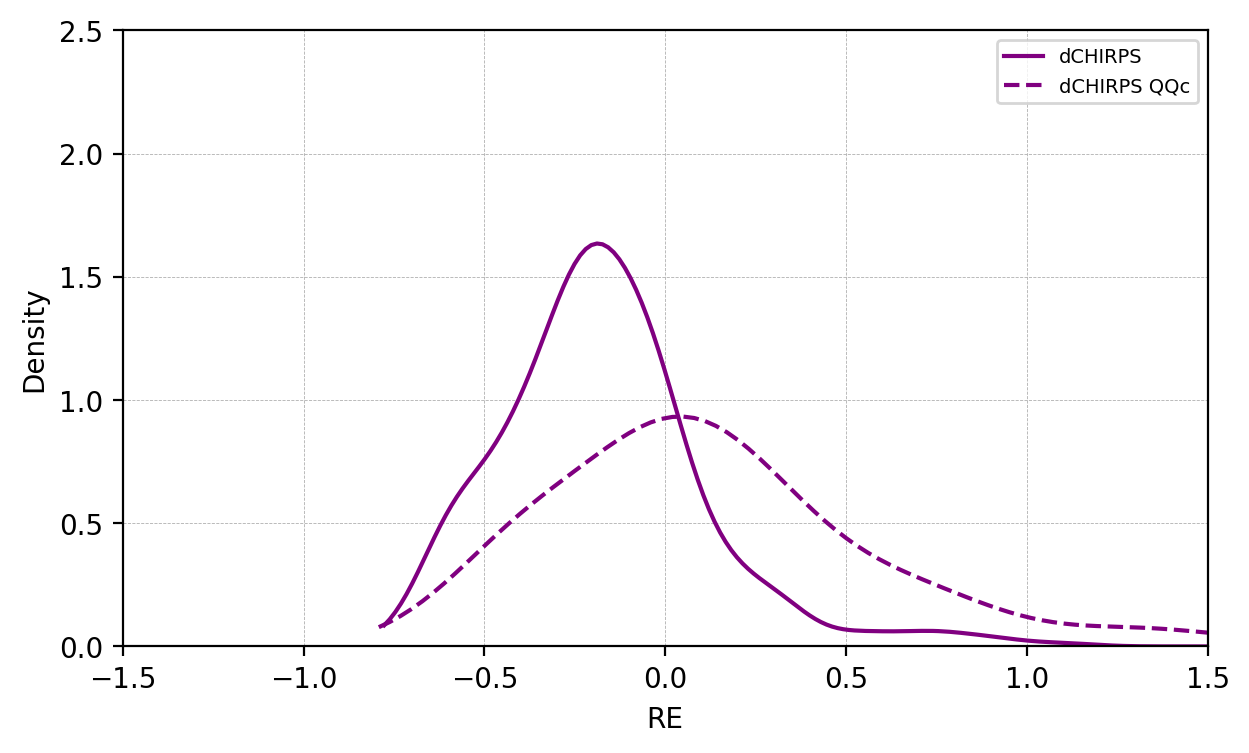

In [19]:
fig = plt.figure(figsize=(7,4),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(DF_val.RE,color=colors[ncolor],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'd{product}',
            clip=(np.nanmin(np.array(DF_val.RE)), np.nanmax(np.array(DF_val.RE))))
sns.kdeplot(DF_val.RE_QQc,color=colors[ncolor],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'd{product} QQc',linestyle='--',
            clip=(np.nanmin(np.array(DF_val.RE_QQc)), np.nanmax(np.array(DF_val.RE_QQc))))
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

Text(0.0, 1.0, '(b) dCHIRPS Extreme Quantile - QQc')

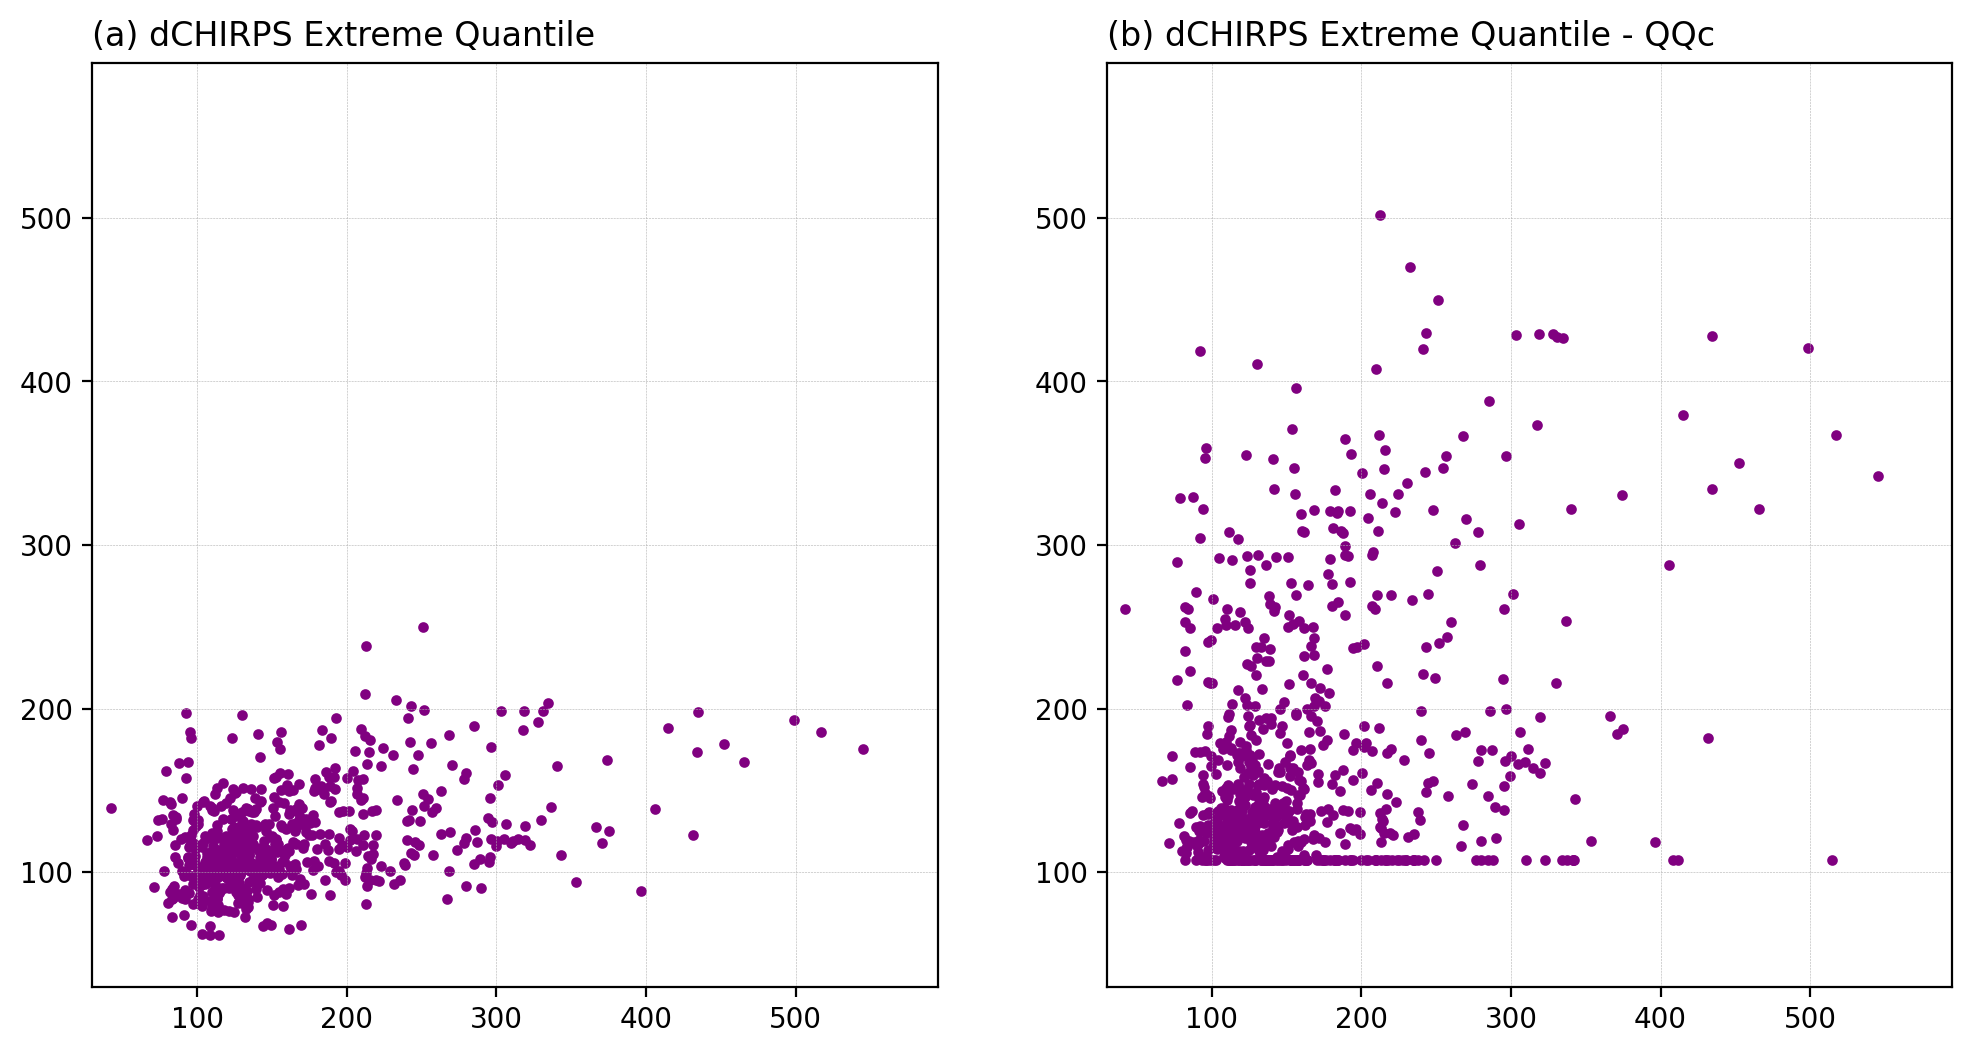

In [32]:
vmin = DF_val.OBS.min()
vmax = DF_val.OBS.max()

fig = plt.figure(figsize=(12,6),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.scatter(DF_val.OBS, DF_val.MEVd, s=8, color=colors[ncolor], vmin=vmin, vmax=vmax)
ax1.set_xlim(30,vmax+50)
ax1.set_ylim(30,vmax+50)
ax1.grid(linestyle='--', linewidth=0.2)
ax1.set_title(f'(a) d{product} Extreme Quantile ', fontsize=12, loc='left')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])

ax1.scatter(DF_val.OBS, DF_val.MEVd_QQc, s=8, color=colors[ncolor], vmin=vmin, vmax=vmax,)
ax1.set_xlim(30,vmax+50)
ax1.set_ylim(30,vmax+50)
ax1.grid(linestyle='--', linewidth=0.2)
ax1.set_title(f'(b) d{product} Extreme Quantile - QQc', fontsize=12, loc='left')